In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from interpret.chefer import *
from models.st_transformer import *
from models.pytorch_lightning import *
from data import *

In [2]:
# : (1) spike and sharp wave (SPSW), 
# (2) generalized periodic epileptiform discharges (GPED), 
# (3) periodic lateralized epileptiform discharges (PLED), 
# (4) eye movement (EYEM), 
# (5) artifact (ARTF) and 
# (6) background (BCKG). 
class_labels = {
    0 : 'Normal', 1 : 'Abnormal'
}

In [3]:
# load the dataset

train, test, val = prepare_TUAB_datasets(sampling_rate=200)

298263 74247 36945
298263 74247 36945


In [4]:

# # compute percentage of "5" class
# counter = 0
# for i in range(len(train)):
#     signal, label = train[i]
#     if label == 5:
#         counter+=1
        

# print(counter/len(train))

In [5]:
print(len(train))

298263


1
torch.Size([16, 2000])


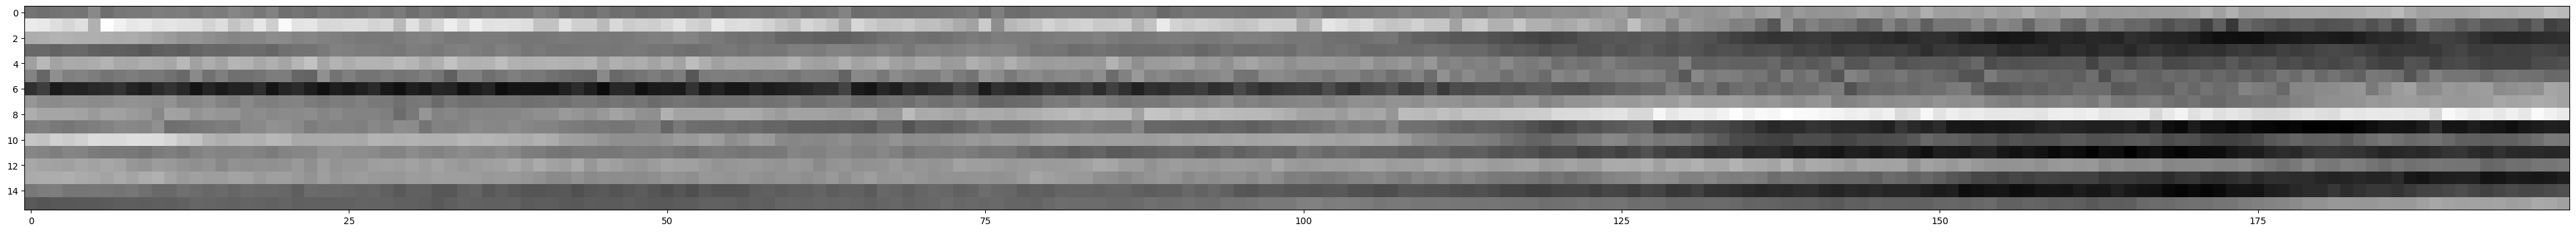

In [6]:
# visualize one example
index = 3120
signal, label = test[index]
plt.figure(figsize=(50,50))
# do first 200 to make figure less hard to see.
plt.imshow(signal[:,:200].numpy(), cmap='gray')
plt.savefig(f"fig/ex{index}.png")
print(label)
print(signal.size())

In [7]:
# load the model
# model = STTransformer(depth=4, n_classes=6, channel_length=1000, dropout=0.5)
 # my model hyperparameters
emb_size = 256
depth = 4 
dropout = 0.5
num_heads = 8
patch_kernel_length = 11  # cqi = 15 - UNUSED
stride = 11  # cqi = 8 - UNUSED

model = STTransformer(emb_size=emb_size, 
                                depth=depth,
                                n_classes=2, 
                                channel_length=2000,
                                dropout=dropout, 
                                num_heads=num_heads,
                                kernel_size=23, 
                                stride=23,
                                kernel_size2=5,
                                stride2=5)
model.load_state_dict(torch.load("saved_weights/st_tuab_transformer_c11s11c5s5.pt"))


<All keys matched successfully>

In [8]:
# get visualization
print(model(signal.unsqueeze(0)))

print(model.channel_attention.get_attn_map().size()) # 1. Can we ignore channel attention? Probably no, because we want to highlight those areas highlighted by channel attention too
print(model.transformer.transformer_blocks[0].mhattn.get_attn_map().size()) # 2. Can we do this first? Yes

tensor([[-0.5628,  1.9279]], grad_fn=<AddmmBackward0>)
torch.Size([1, 16, 16])
torch.Size([1, 8, 9, 9])


Top 5 Scores in Increasing Order
Class Abnormal with score: 1.0872833728790283
Class Normal with score: 0.3302532434463501
True Label: Abnormal


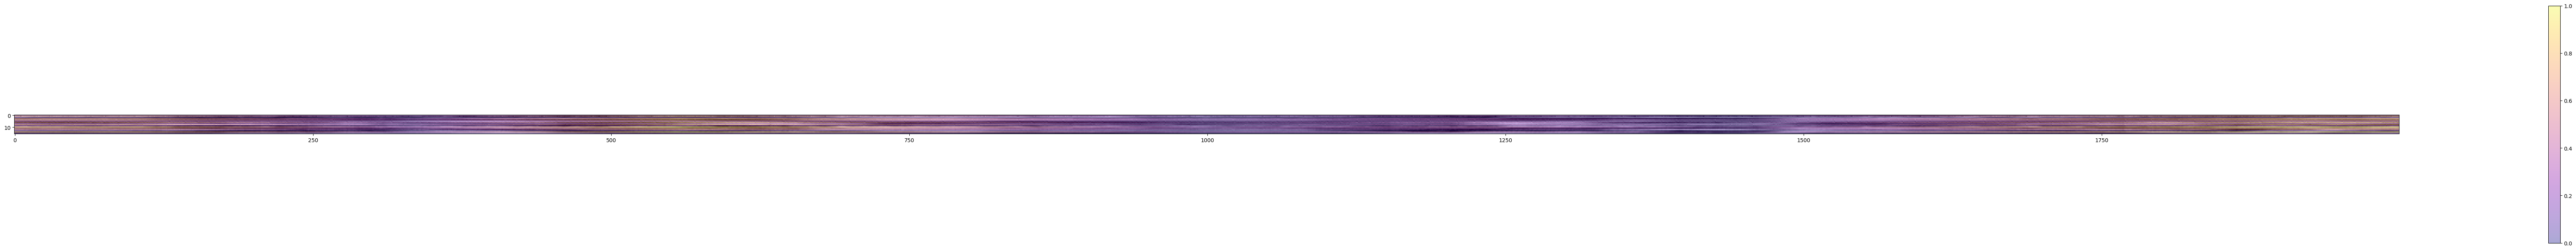

In [9]:
interpreter = STTransformerInterpreter(model=model)
sequence, attribution = interpreter.visualize(signal.unsqueeze(0), class_index = None, save_path="fig/sequence_highlighted_tuab.png", figsize=(100,16), method="linear")
# plt.imshow(vis)
interpreter.get_top_classes(signal.unsqueeze(0), class_labels=class_labels, n=2)
print("True Label:", class_labels[label])

In [10]:
# zooming in on first half


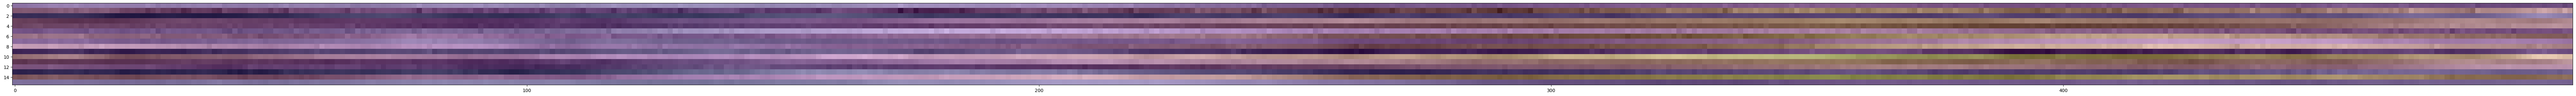

In [11]:
# zooming in on highlighted regions 
start = 200 
end = 700
plt.figure(figsize=(100, 32))
plt.imshow(sequence[:,start:end], cmap='gray')
plt.imshow(attribution[:,start:end], alpha=0.3, cmap='plasma')

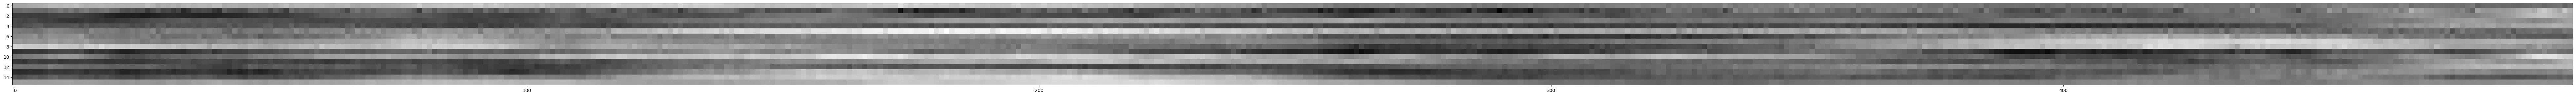

In [12]:
plt.figure(figsize=(100, 32))
plt.imshow(sequence[:,start:end], cmap='gray')

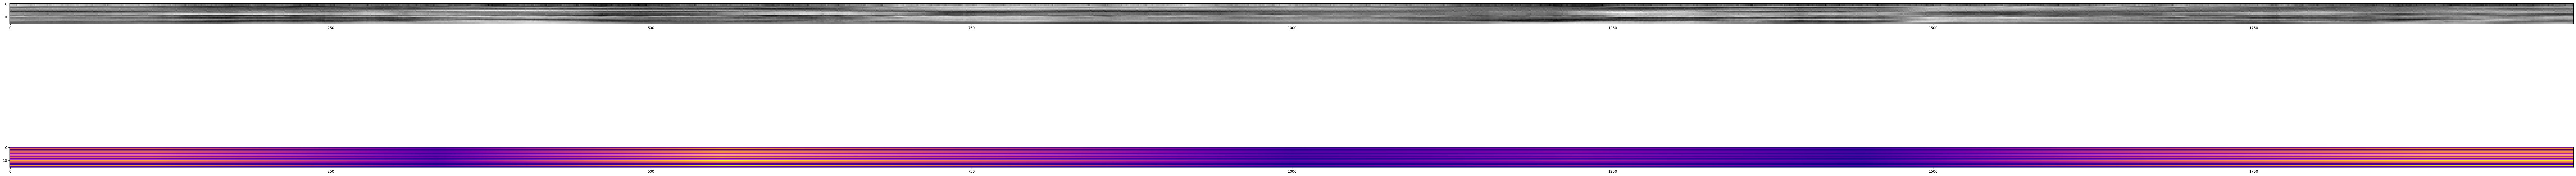

In [13]:
# zoom in on the highlighted features
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(100,16))  # 1 row, 2 columns of subplots


ax1.imshow(sequence, cmap='gray')
ax2.imshow(attribution, cmap='plasma')
plt.tight_layout()
# plt.subplot_tool()
plt.savefig("fig/channel_attention_tuab.png")

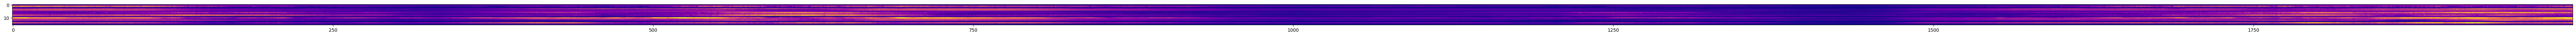

In [14]:
plt.figure(figsize=(100,32))
plt.imshow((sequence * attribution)[:200], cmap='plasma')

### Plot abnormal CAM vs normal CAM vs original onto subplots

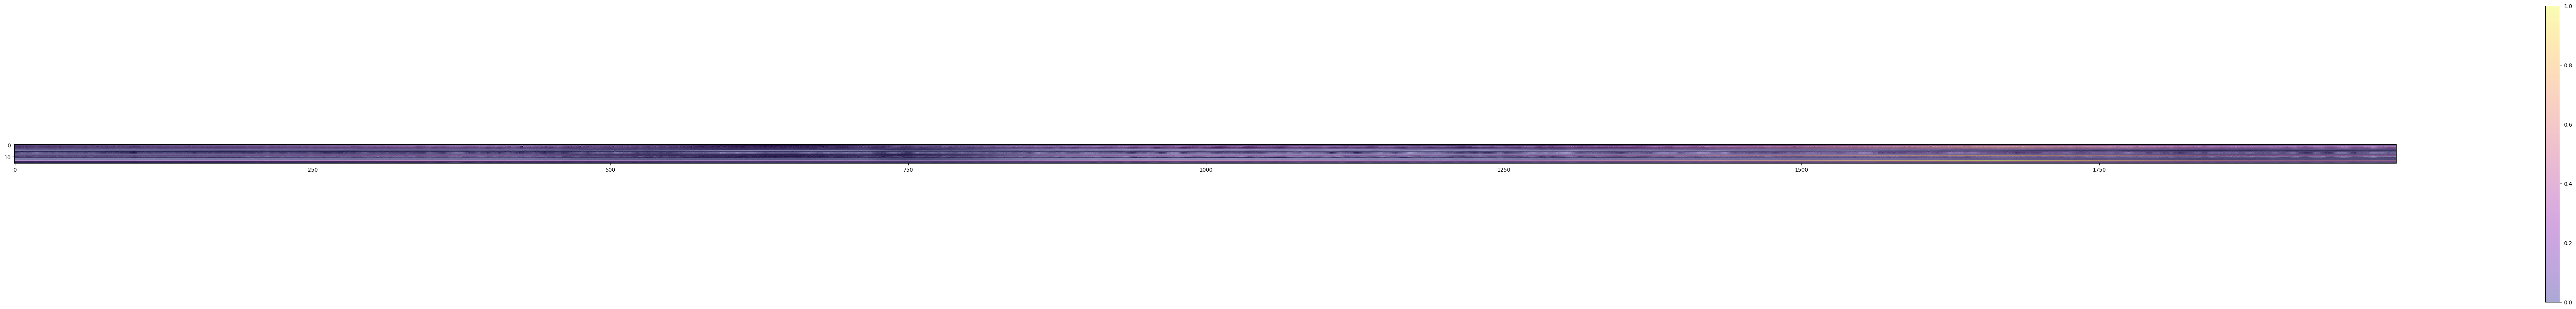

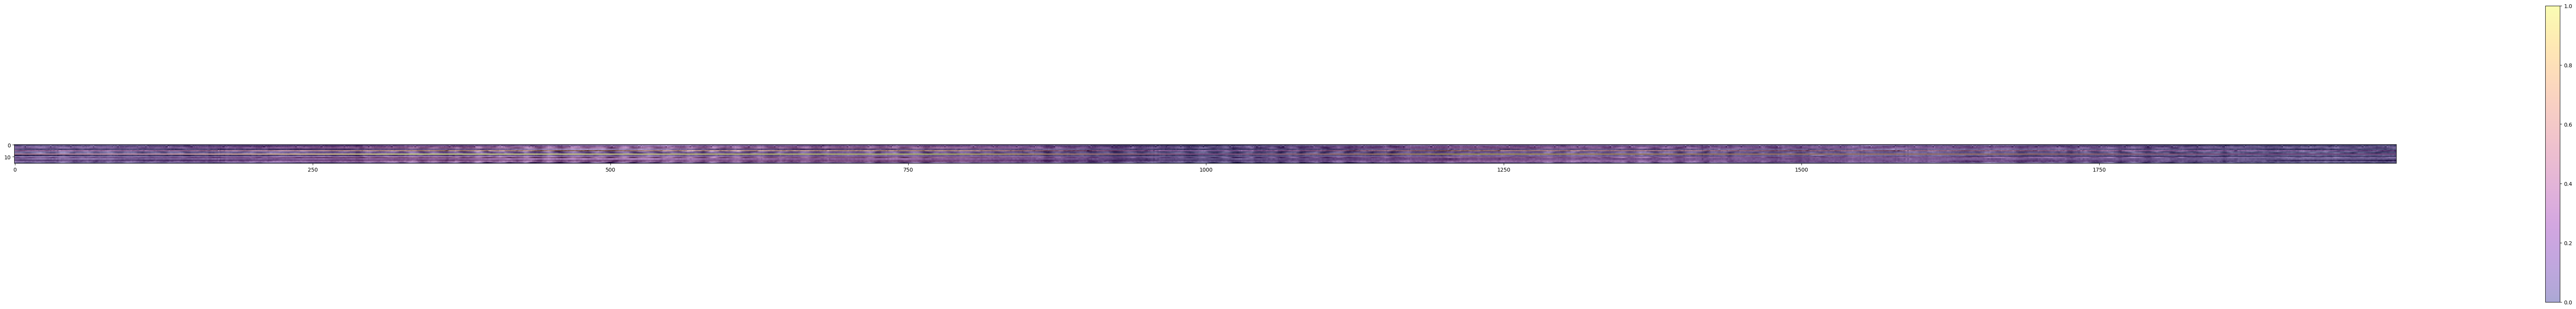

In [15]:
# abnormal image

abnormal_seq, ab_label = test[0]
normal_seq, label = test[2319]
# print(interpreter.model(abnormal_seq.unsqueeze(0).cuda()))
# print(interpreter.model(normal_seq.unsqueeze(0).cuda()))
# ab seq and seq get converted to numpy!
ab_seq, ab_cam = interpreter.visualize(abnormal_seq.unsqueeze(0), class_index=ab_label, method="linear")
seq ,cam = interpreter.visualize(normal_seq.unsqueeze(0), class_index=label, method="linear")

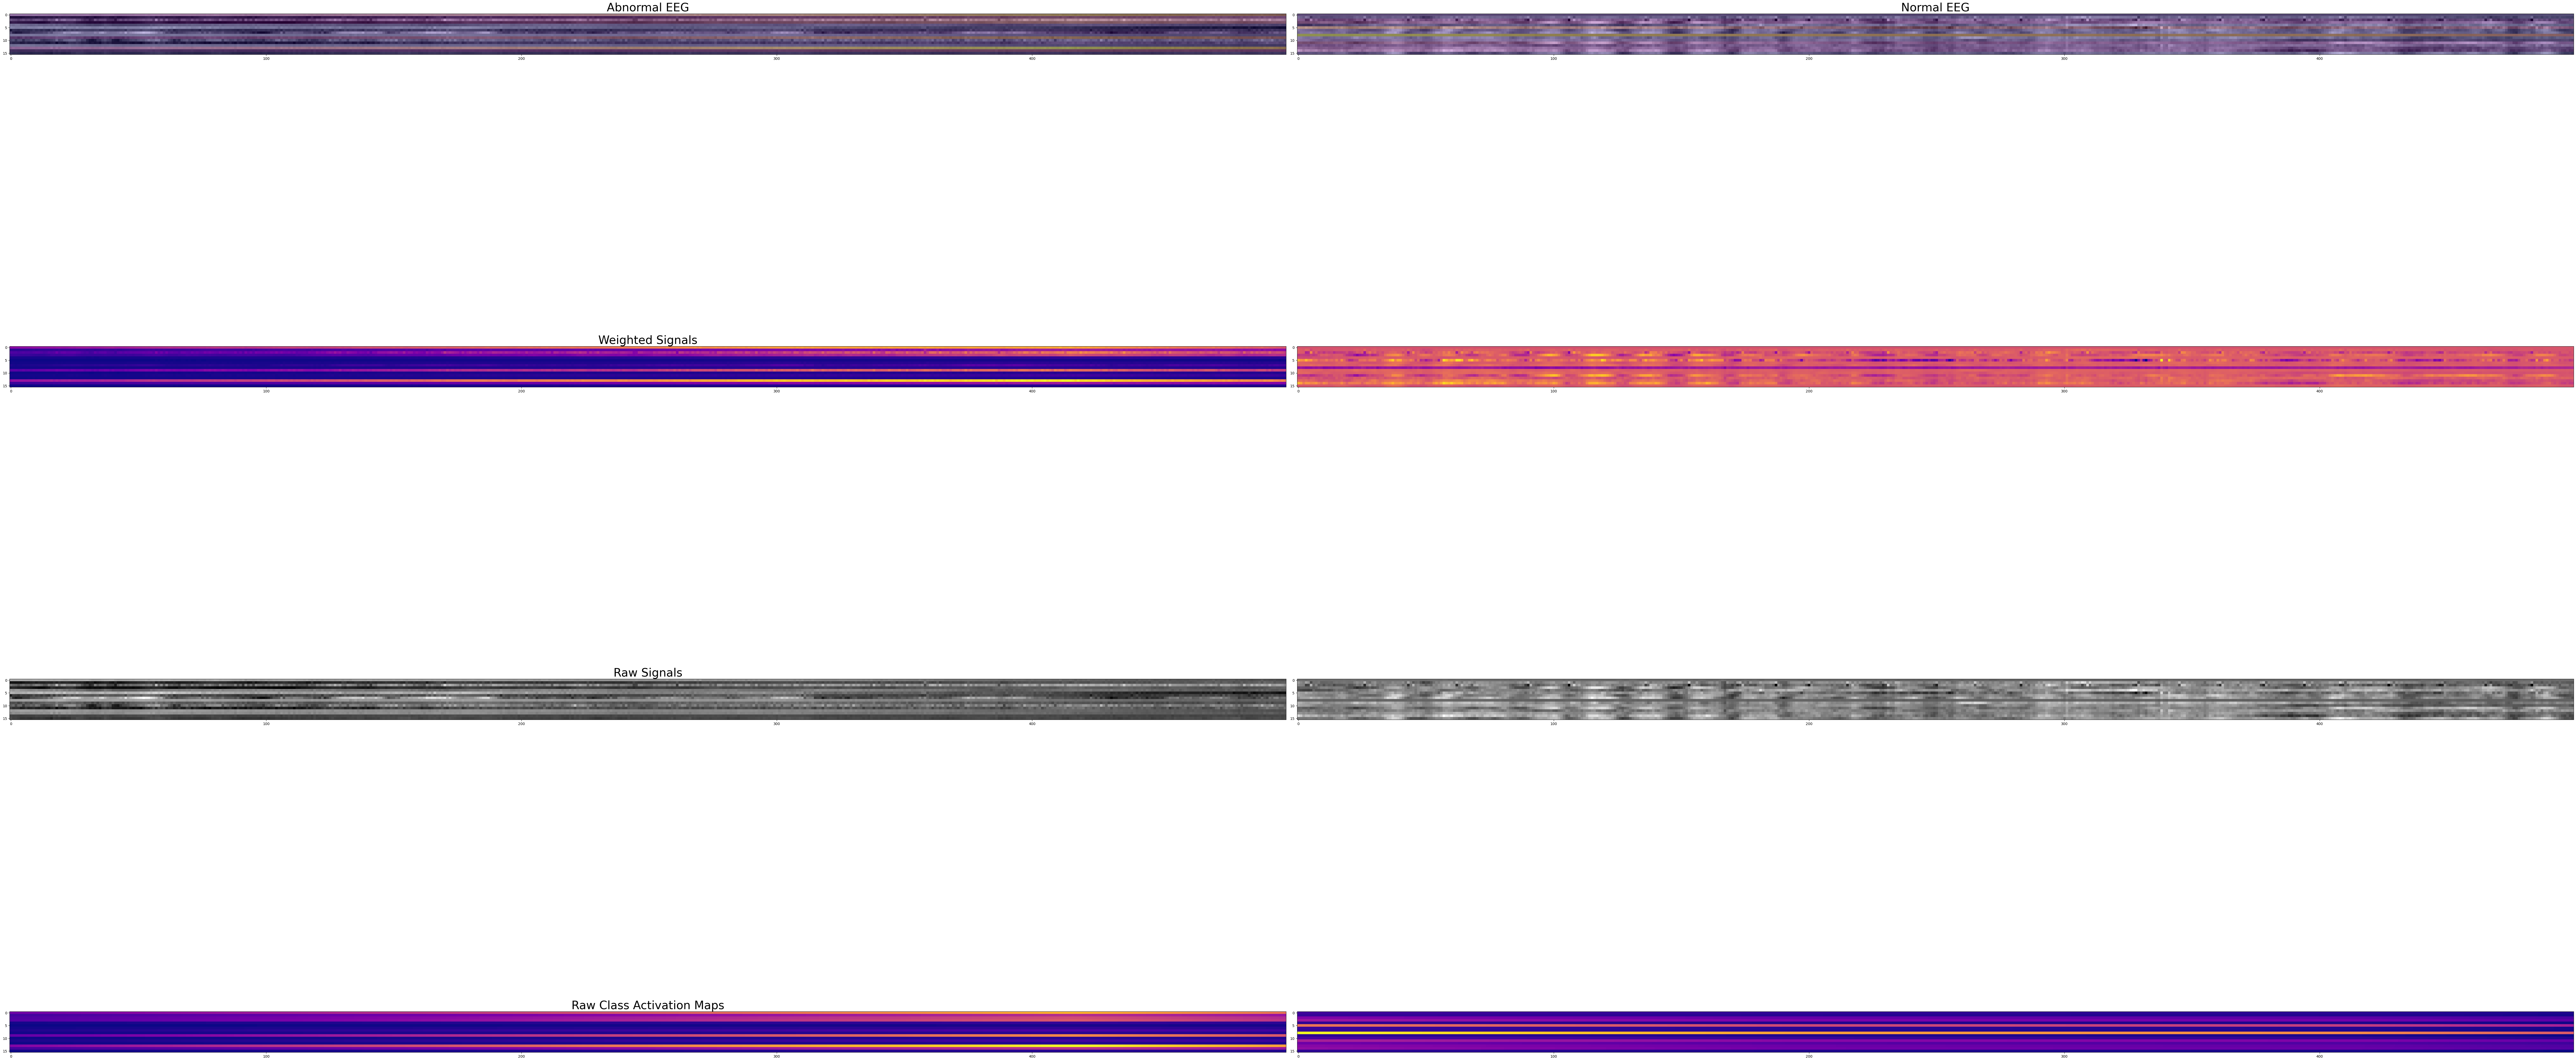

In [16]:
# we will do first 500 values or something like that
fig, ax = plt.subplots(4,2, figsize=(100,60))  # 4 row, 2 columns of subplots

start = 1250
end = 1750
# first row highlights
ax[0,0].set_title("Abnormal EEG", fontsize=32)
ax[0,0].imshow(ab_seq[:, start:end], cmap='gray')
ax[0,0].imshow(ab_cam[:, start:end], cmap='plasma', alpha=0.3)
ax[0,1].set_title("Normal EEG", fontsize=32)
ax[0,1].imshow(normal_seq[:, start:end], cmap='gray')
ax[0,1].imshow(cam[:, start:end], cmap='plasma', alpha=0.3)

# second row cam attribution 
ax[1,0].set_title("Weighted Signals", fontsize=32)
ax[1,0].imshow(ab_seq[:, start:end] * ab_cam[:, start:end] ,cmap='plasma')
ax[1,1].imshow(normal_seq[:, start:end] * cam[:, start:end], cmap='plasma')

# third row raw signals
ax[2,0].set_title("Raw Signals", fontsize=32)
ax[2,0].imshow(ab_seq[:,start:end], cmap='gray')
ax[2,1].imshow(normal_seq[:, start:end], cmap='gray')


# fourth row raw cam
ax[3,0].set_title("Raw Class Activation Maps", fontsize=32)
ax[3,0].imshow(ab_cam[:,start:end], cmap='plasma')
ax[3,1].imshow(cam[:, start:end], cmap='plasma')

plt.tight_layout()
plt.savefig(f"fig/TUAB_s{start}_e{end}")
